## Job Data Scraper from Karkidi

This contains a function to scrape job postings from the Karkidi website.  
It searches for jobs based on a keyword and number of pages, then extracts job title, company, location, experience, key skills, and a summary.  
A small delay is added between page requests to avoid overloading the server.


In [17]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time

def fetch_jobs_from_karkidi(search_term="data science", max_pages=5):
    user_agent = {'User-Agent': 'Mozilla/5.0'}
    base_url = "https://www.karkidi.com/Find-Jobs/{}/all/India?search={}"
    job_data = []

    for page_num in range(1, max_pages + 1):
        formatted_query = search_term.replace(" ", "%20")
        full_url = base_url.format(page_num, formatted_query)
        print(f"Fetching data from page {page_num}...")

        try:
            response = requests.get(full_url, headers=user_agent)
            response.raise_for_status()  # Raise exception for HTTP errors
            html_doc = BeautifulSoup(response.text, "html.parser")
            job_cards = html_doc.find_all("div", class_="ads-details")
        except Exception as fetch_err:
            print(f"Failed to retrieve page {page_num}: {fetch_err}")
            continue

        for card in job_cards:
            try:
                job_title = card.find("h4").get_text(strip=True)
                company_name = card.find("a", href=lambda x: x and "Employer-Profile" in x).get_text(strip=True)
                job_location = card.find("p").get_text(strip=True)
                required_experience = card.find("p", class_="emp-exp").get_text(strip=True)

                skills_section = card.find("span", string="Key Skills")
                key_skills = skills_section.find_next("p").get_text(strip=True) if skills_section else ""

                summary_section = card.find("span", string="Summary")
                job_summary = summary_section.find_next("p").get_text(strip=True) if summary_section else ""

                job_data.append({
                    "Job Title": job_title,
                    "Company": company_name,
                    "Location": job_location,
                    "Experience Required": required_experience,
                    "Summary": job_summary,
                    "Key Skills": key_skills
                })
            except Exception as parse_err:
                print(f"Error while parsing job entry: {parse_err}")
                continue

        time.sleep(1)  # Delay to prevent overloading the server

    return pd.DataFrame(job_data)


##Job skill clustering using kmeans

Fetching job data...
Fetching data from page 1...
Fetching data from page 2...
Fetching data from page 3...
Fetching data from page 4...
Fetching data from page 5...
Fetching data from page 6...
Clustering job data...


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Elbow plot saved as 'elbow_plot.png'.
Choose the number of clusters (based on Elbow plot): 5
Silhouette Score with 5 clusters: 0.6249
Saving results...
✅ Done! 'clustered_jobs.csv' and 'job_model.pkl' have been saved.


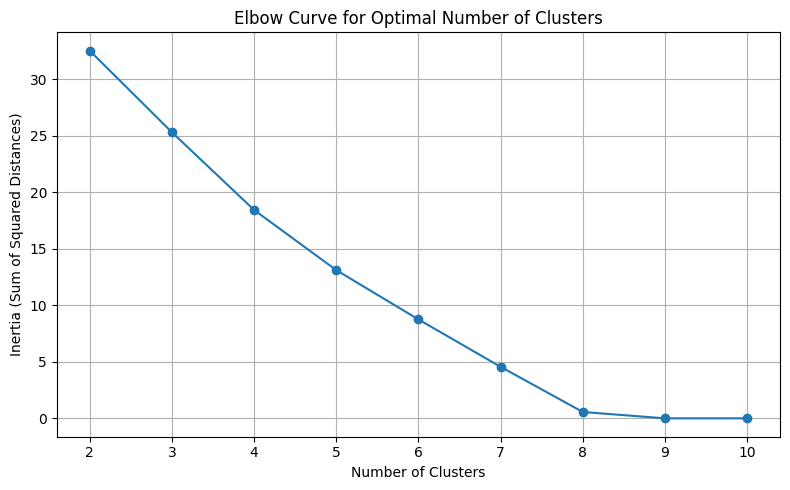

In [19]:
# Clustering Logic
import joblib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def clean_skills_column(skills_col):
    """Convert skills text to lowercase and remove commas for vectorization."""
    return skills_col.fillna("").str.lower().str.replace(",", " ").str.replace("  ", " ", regex=False)

def plot_elbow_chart(vectors, max_clusters=10):
    """Determine the best k using the Elbow Method and visualize it."""
    distortions = []

    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(vectors)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, max_clusters + 1), distortions, marker='o')
    plt.title("Elbow Curve for Optimal Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia (Sum of Squared Distances)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("elbow_plot.png")
    print("Elbow plot saved as 'elbow_plot.png'.")

    optimal_k = int(input("Choose the number of clusters (based on Elbow plot): "))
    return optimal_k

def perform_clustering(dataframe):
    df = dataframe.copy()
    cleaned_skills = clean_skills_column(df["Key Skills"])

    tfidf = TfidfVectorizer()
    tfidf_matrix = tfidf.fit_transform(cleaned_skills)

    # Select optimal cluster count
    num_clusters = plot_elbow_chart(tfidf_matrix, max_clusters=10)

    # Train final KMeans model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)

    df["Cluster"] = cluster_labels

    # Evaluate clustering quality
    silhouette = silhouette_score(tfidf_matrix, cluster_labels)
    print(f"Silhouette Score with {num_clusters} clusters: {silhouette:.4f}")

    # Save model and artifacts
    model_package = {
        "kmeans_model": kmeans,
        "vectorizer": tfidf,
        "features": tfidf_matrix.toarray(),
        "labels": cluster_labels
    }
    joblib.dump(model_package, "job_model.pkl")

    return df

# ✅ Part 3: Main Execution
if __name__ == "__main__":
    print("Fetching job data...")
    job_df = fetch_jobs_from_karkidi(search_term="data science", max_pages=6)

    print("Clustering job data...")
    results_df = perform_clustering(job_df)

    print("Saving results...")
    results_df.to_csv("clustered_jobs.csv", index=False)

    print("✅ Done! 'clustered_jobs.csv' and 'job_model.pkl' have been saved.")


##saving and loading

In [20]:
import joblib

def persist_model(tfidf_vec, clustering_model, filename="job_model.pkl"):
    """Saves both the vectorizer and the model into a single .pkl file."""
    bundle = {
        "vectorizer": tfidf_vec,
        "model": clustering_model
    }
    joblib.dump(bundle, filename)

def retrieve_model(filename="job_model.pkl"):
    """Loads the saved vectorizer and model from file."""
    return joblib.load(filename)
